# Analytics
How good are typical solutions to the packing problem?

The problem to solve is to select a subset of tracks from the library that sum closest to the desired playlist length. That is, solve
$$
\min_{x_i} | \Sigma_{i} (x_i w_i) - W |
$$
where $W$ is the target playlist length, $w_i$ is the length of the $i$th track and $x_i \in \{0,1\}$ is the indicator variable for whether the $i$th track is included or not. 

The integer programming package I'm using, `mip`, can't solve that type of objective, so instead I solve the following related problem
$$
\min_{x_i} \Sigma_{i} (x_i w_i) - W
$$
subject to constraint
$$
\Sigma_{i} (x_i w_i) - W \ge 0
$$
This form should find solutions that slightly overshoot the target. In practice this seems to work pretty well. 

Below I explore how the typical, best and worst case solutions perform for a range of library sizes and target playlist lengths. 

In [22]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from app.pack import solve, SolverException

In [2]:
# get spotify api object. running this should create this as `sp` 
%run spotipy_mwe.py

In [4]:
# get tracks from library
offset = 0
limit = 50
total = limit
tracks = []
while offset<total:
    r = sp.current_user_saved_tracks(limit=limit, offset=offset)
    tracks += [
        (t['track']['name'], t['track']['id'], t['track']['duration_ms']) 
            for t in r['items'] 
    ]
    if total==limit:
        total = r['total']
    offset += limit
    print(offset, total)

50 189
100 189
150 189
200 189


SyntaxError: 'return' outside function (<ipython-input-4-91c3de17cdf8>, line 16)

## Library summary stats

In [8]:
df = pd.DataFrame(data=tracks, columns=['name', 'id', 'length_ms'])
df['length_td'] = pd.to_timedelta(df.length_ms, unit='ms')
df.head()

,name,id,length_ms,length_td
0,Gibraltar,2Ji6pcpNIuRPSilgKHjnN6,232986,00:03:52.986000
1,"Piano Sonata in C Major, Hob. XVI:50: I. Allegro",2uN6iw54P6ETSKf02esnle,642893,00:10:42.893000
2,Below The Valleys,32Kg7L3mgzcekEo7z9pypH,181000,00:03:01
3,Can We Pretend,0S5ZoKKZD3bllkvhEoPimZ,229573,00:03:49.573000
4,Clair de Lune,273VxALm722DRN4PNujOF8,667733,00:11:07.733000


In [9]:
df.sort_values('length_ms', ascending=True).head()

,name,id,length_ms,length_td
154,"Wo gehest du hin?, BWV 166: ChoraleL Wer weiss...",1Ltm49dwpAV7vsIdgxeaAT,72506,00:01:12.506000
76,"Der Friede sei mit dir, BWV 158: Chorale: Hier...",10dHUQIUSVSUEZULZZs9Hh,82853,00:01:22.853000
64,Isn't She Lovely,23H8PpuhyTDHwpqcDm7vS6,86925,00:01:26.925000
127,Bach Vibrations (after J.S. Bach's 2-Part Inve...,4bJLMR5pMBLMNC56VyPNPJ,99626,00:01:39.626000
38,"Goldberg Variations, BWV 988: Aria",2H4kTqp11QWNh8gumWgiyf,112693,00:01:52.693000


In [10]:
df.sort_values('length_ms', ascending=False).head()

,name,id,length_ms,length_td
124,Konnakkol Crosstalk,4amqs0UrwU02MGFufm1s88,875674,00:14:35.674000
116,Beethoven: String Quartet No. 12 in E-Flat Maj...,0SH5FpJQaR7xbLzEF9ZFeF,859746,00:14:19.746000
86,a blooming bloodfruit in a hoodie,3UR0Oa02msUT9s9hHSE9ya,777346,00:12:57.346000
102,"Summer Music, Op. 31",1U4j5G7Le6kzQkjAzaJijd,683280,00:11:23.280000
4,Clair de Lune,273VxALm722DRN4PNujOF8,667733,00:11:07.733000


In [ ]:
df['length_m'] = df.length_ms/60000

In [19]:
df.length_td.describe()

count                       189
mean     0 days 00:04:52.509275
std      0 days 00:02:16.340442
min      0 days 00:01:12.506000
25%      0 days 00:03:19.853000
50%      0 days 00:04:21.881000
75%             0 days 00:05:42
max      0 days 00:14:35.674000
Name: length_td, dtype: object

In [47]:
# total library length
df.length_td.sum()

Timedelta('0 days 15:21:24.253000')

Text(0,0.5,'count')

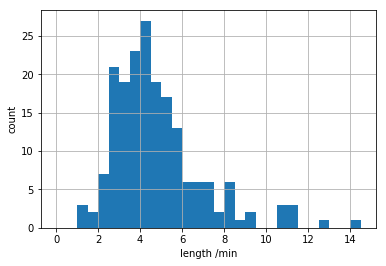

In [18]:
fig, ax = plt.subplots()
df.length_m.hist(bins=np.arange(0,df.length_m.max(),0.5), ax=ax)
ax.set_xlabel('length /min')
ax.set_ylabel('count')

## Explore typical solution

In [48]:
w = [x/1000 for x in df.length_ms]
Ws = np.array([1,2,3,5,10,25,60,90,120,240,60*12,60*15])
n_tracks = []
solve_error = []
for W in Ws:
    try:
        selected, error = solve(W*60, w)
    except SolverException:
        selected, error = [], np.nan
    n_tracks.append(len(selected))
    solve_error.append(error)

In [49]:
df_ = pd.DataFrame(
    data=[(W, e, n) for W, e, n in zip(Ws, solve_error, n_tracks)], 
    columns=['target_m', 'error_s', 'num_tracks']
)
df_

,target_m,error_s,num_tracks
0,1,12.506,1
1,2,4.053,1
2,3,1.000,1
3,5,0.117,2
4,10,0.027,5
5,25,0.141,7
6,60,0.086,14
7,90,0.061,18
8,120,0.586,20
9,240,0.147,46


(-43.95, 944.95)

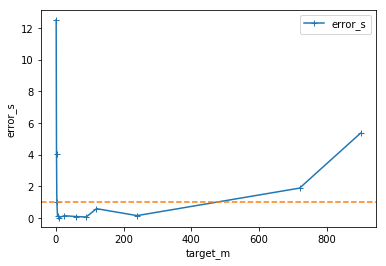

In [50]:
fig, ax = plt.subplots()
df_.plot(x='target_m', y='error_s', marker='+', ax=ax)
ax.set_ylabel('error_s')
xlim = ax.get_xlim()
ax.plot(xlim, [1,1], linestyle='--')
ax.set_xlim(xlim)

solution within a second of target are achieved for most reasonable playlist lengths (above the smallest song length and below half the total library length)

What is the variance in the solution depending on your library?

For this I'll resample my library to simulate different library choices of different users. 

In [54]:
Ws = np.array([1,2,3,5,10,25,60,90,120,240,60*7.5])
data = []
for s in range(5):
    df_sample = df.sample(frac=0.5)
    w = [x/1000 for x in df_sample.length_ms]
    for W in Ws:
        try:
            selected, error = solve(W*60, w)
        except SolverException:
            selected, error = [], np.nan
        data.append((s, W, error, len(selected)))

In [62]:
df_ = pd.DataFrame(data=data, columns=['sample', 'target_m', 'error_s', 'num_tracks'])
df_.pivot_table(index='target_m', values=['error_s','num_tracks'])
df_.groupby('target_m').agg({'error_s':['mean', 'min', 'max', 'std'], 'num_tracks':['mean', 'min', 'max', 'std']})

error_s                           num_tracks                   
             mean     min     max       std       mean min max        std
target_m                                                                 
1.0       27.0220  22.853  39.626  7.263124        1.0   1   1   0.000000
2.0        5.3964   4.053  10.770  3.003934        1.0   1   1   0.000000
3.0        3.7948   1.240  10.588  3.907307        1.2   1   2   0.447214
5.0        0.2136   0.117   0.570  0.199375        2.0   2   2   0.000000
10.0       0.0182   0.006   0.044  0.014873        3.4   3   4   0.547723
25.0       0.0770   0.002   0.145  0.063867        7.0   5   9   1.414214
60.0       0.1280   0.072   0.193  0.050224       13.4  12  15   1.140175
90.0       0.1764   0.021   0.335  0.149813       19.8  18  22   1.483240
120.0      0.3490   0.097   0.634  0.191472       24.6  23  26   1.341641
240.0      0.4028   0.036   1.152  0.461664       50.4  48  52   1.516575
450.0      0.0560   0.056   0.056       NaN       16.8   0  84  37.565942

(0, 5)

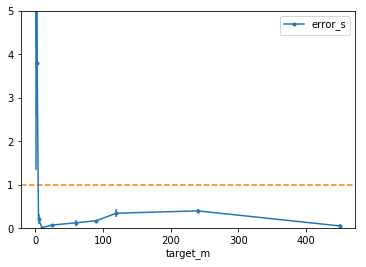

In [67]:
fig, ax = plt.subplots()

means = df_.groupby('target_m').agg({'error_s':'mean'})
minmax = df_.groupby('target_m').agg({'error_s':['min', 'max']})

means.plot(ax=ax, marker='.', yerr=minmax.values.T)

xlim = ax.get_xlim()
ax.plot(xlim, [1,1], linestyle='--')
ax.set_xlim(xlim)
ax.set_ylim([0,5])

In [71]:
Ws = np.array([1,2,3,5,10,25,60,90,120,240,60*7.5,60*15])
lib_sizes = [0.05,0.25,0.5,1.0]
data = []
for lib_size in lib_sizes:
    for s in range(5):
        df_sample = df.sample(frac=lib_size)
        w = [x/1000 for x in df_sample.length_ms]
        N = len(w)
        for W in Ws:
            try:
                selected, error = solve(W*60, w)
            except SolverException:
                selected, error = [], np.nan
            data.append((s, N, W, error, len(selected)))

In [80]:
df__ = pd.DataFrame(data=data, columns=['sample', 'lib_size', 'target_m', 'error_s', 'num_tracks'])

In [81]:
means = df__.pivot_table(index='target_m', columns='lib_size', values=['error_s'])
means

error_s                           
lib_size       9        47       94       189
target_m                                     
1.0       120.3510  25.4234  15.3898  12.5060
2.0        60.3510  22.9646   8.0832   4.0530
3.0        15.9066   4.2864   1.1478   1.0000
5.0        28.8118   0.7876   0.4046   0.1170
10.0        7.2500   0.0410   0.0286   0.0404
25.0        0.8924   0.0312   0.0604   0.0492
60.0       34.6160   0.1662   0.1814   0.1444
90.0           NaN   0.1862   0.2690   0.2132
120.0          NaN   0.3554   0.1274   0.2486
240.0          NaN   0.0190   0.3400   0.6306
450.0          NaN      NaN   1.8690   1.3172
900.0          NaN      NaN      NaN   0.5592

In [82]:
mins = df__.pivot_table(index='target_m', columns='lib_size', values=['error_s'], aggfunc='min')
mins

error_s                        
lib_size      9       47      94      189
target_m                                 
1.0       101.160  12.506  12.506  12.506
2.0        41.160   4.053   4.053   4.053
3.0         1.259   1.000   1.000   1.000
5.0         0.200   0.200   0.117   0.117
10.0        0.908   0.021   0.008   0.021
25.0        0.317   0.003   0.000   0.002
60.0       34.616   0.005   0.026   0.079
90.0          NaN   0.004   0.037   0.049
120.0         NaN   0.169   0.052   0.025
240.0         NaN   0.019   0.009   0.323
450.0         NaN     NaN   1.869   0.020
900.0         NaN     NaN     NaN   0.072

In [83]:
maxs = df__.pivot_table(index='target_m', columns='lib_size', values=['error_s'], aggfunc='max')
maxs

error_s                        
lib_size      9       47      94      189
target_m                                 
1.0       176.914  39.626  26.925  12.506
2.0       116.914  36.852  10.770   4.053
3.0        56.914  14.506   1.259   1.000
5.0        55.666   1.666   0.548   0.117
10.0       16.355   0.065   0.060   0.059
25.0        1.816   0.078   0.147   0.136
60.0       34.616   0.293   0.328   0.210
90.0          NaN   0.469   0.522   0.521
120.0         NaN   0.533   0.219   0.620
240.0         NaN   0.019   1.227   1.265
450.0         NaN     NaN   1.869   2.437
900.0         NaN     NaN     NaN   1.695